### Identifying Fraudulent Activities
### Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

---------
### Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:

For each user, determine her country based on the numeric IP address.
Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?






### Data
#### Fraud data table

information about each user first transaction

- user_id : Id of the user. Unique by user
- signup_time : the time when the user created her account (GMT time)
- purchase_time : the time when the user bought the item (GMT time)
- purchase_value : the cost of the item purchased (USD)
- device_id : the device id. You can assume that it is unique by device. I.e., 2 transactions with the same device ID means that the same physical device was used to buy
- source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser).
- browser : the browser used by the user.
- sex : user sex: Male/Female
- age : user age
- ip_address : user numeric ip address
- class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).



#### IpAddress_to_Country

mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ip address belongs to the corresponding country.

- lower_bound_ip_address : the lower bound of the numeric ip address for that country
- upper_bound_ip_address : the upper bound of the numeric ip address for that country
- country : the corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from IPython.display import display , Image 
import warnings
warnings.filterwarnings('ignore')



from sklearn.model_selection import train_test_split, KFold, GridSearchCV ,cross_val_score

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score ,classification_report
from sklearn.metrics import roc_curve , auc, f1_score , recall_score , precision_score

import xgboost as xgb
from xgboost import plot_importance

In [2]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)


fraud_df = pd.read_csv('./ML Identifying Fraudulent Activities with solution/Fraud_Data.csv',parse_dates=['signup_time','purchase_time'])

ip_df =  pd.read_csv('./ML Identifying Fraudulent Activities with solution/IpAddress_to_Country.csv')



In [3]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:

fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [6]:

fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [7]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [8]:
# Add Country to Fraud Data

countries=[]
for ip in fraud_df['ip_address']:
    country = list(ip_df[(ip_df['lower_bound_ip_address']<ip) & (ip_df['upper_bound_ip_address']>ip)]['country'].values)
    
    if len(country)==1:
        countries.append(country[0])
    else:
        countries.append('NA')
        
        
fraud_df['country'] = countries

fraud_df.head()  

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [9]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [10]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
 11  country         151112 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


In [11]:
# check the counts of countries

fraud_df.country.value_counts()

United States                           58049
NA                                      21966
China                                   12038
Japan                                    7306
United Kingdom                           4490
Korea Republic of                        4162
Germany                                  3646
France                                   3161
Canada                                   2975
Brazil                                   2961
Italy                                    1944
Australia                                1844
Netherlands                              1680
Russian Federation                       1616
India                                    1310
Taiwan; Republic of China (ROC)          1237
Mexico                                   1121
Sweden                                   1090
Spain                                    1027
South Africa                              838
Switzerland                               785
Poland                            

### Feature Engineering

Create some variables to check that user is suspicious or not. 

- Create variable 'time_interval' =  purchase_time - signup_time ;

- Create variable 'ip_count', To know that how many ip address are in common ;

- Create variable 'device_id_count', To know that how many device are used in common by different users ;

In [12]:
# create time_interval  
fraud_df['time_interval'] = (fraud_df.purchase_time-fraud_df.signup_time).astype('timedelta64[s]')


# create ip_count
n_ip_shared = fraud_df.ip_address.value_counts()
fraud_df['ip_count'] = fraud_df.ip_address.map(n_ip_shared)


# create device_id_count
n_dev_shared = fraud_df.device_id.value_counts()
fraud_df['device_id_count'] = fraud_df.device_id.map(n_dev_shared)

Create some variables to capture the seasonality trend.
- Create variables 'signup_day_of_week' , 'signup_week_of_year' , 'purchase_day_of_week' , 'purchase_week_of_year'

In [13]:
# get the signup_day_of_week, signup_week_of_year, purchase_day_of_week, purchase_week_of_year

fraud_df['signup_day_of_week'] = fraud_df['signup_time'].apply(lambda x: x.dayofweek)
fraud_df['signup_week_of_year'] = fraud_df['signup_time'].apply(lambda x: x.week)

fraud_df['purchase_day_of_week'] = fraud_df['purchase_time'].apply(lambda x: x.dayofweek)
fraud_df['purchase_week_of_year'] = fraud_df['purchase_time'].apply(lambda x: x.week)

In [14]:
# count device_id
len(np.unique(fraud_df['device_id']))

137956

In [15]:
# count source, browser, sex, country
(len(np.unique(fraud_df['source'])), len(np.unique(fraud_df['browser'])) , \
 len(np.unique(fraud_df['sex'])) ,len(np.unique(fraud_df['country']))  )

(3, 5, 2, 182)

In [16]:
new_fraud_df = fraud_df.copy()
new_fraud_df.drop(['user_id','signup_time','purchase_time','device_id','ip_address'], axis=1, inplace=True)


new_fraud_df.head()

,purchase_value,source,browser,sex,age,class,country,time_interval,ip_count,device_id_count,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year
0,34,SEO,Chrome,M,39,0,Japan,4506682.0,1,1,1,9,5,16
1,16,Ads,Chrome,F,53,0,United States,17944.0,1,1,6,23,0,24
2,15,SEO,Opera,M,53,1,United States,1.0,12,12,3,1,3,1
3,44,SEO,Safari,M,41,0,NA,492085.0,1,1,1,18,0,19
4,39,Ads,Safari,M,45,0,United States,4361461.0,1,1,1,30,2,37


### Data Exploration

In [17]:
new_fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   purchase_value         151112 non-null  int64  
 1   source                 151112 non-null  object 
 2   browser                151112 non-null  object 
 3   sex                    151112 non-null  object 
 4   age                    151112 non-null  int64  
 5   class                  151112 non-null  int64  
 6   country                151112 non-null  object 
 7   time_interval          151112 non-null  float64
 8   ip_count               151112 non-null  int64  
 9   device_id_count        151112 non-null  int64  
 10  signup_day_of_week     151112 non-null  int64  
 11  signup_week_of_year    151112 non-null  int64  
 12  purchase_day_of_week   151112 non-null  int64  
 13  purchase_week_of_year  151112 non-null  int64  
dtypes: float64(1), int64(9), object(4)
m

In [18]:
new_fraud_df.describe()

,purchase_value,age,class,time_interval,ip_count,device_id_count,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000
mean,36.935372,33.140704,0.093646,4.932029e+06,1.602719,1.684367,3.027265,16.501740,3.011819,24.658571
std,18.322762,8.617733,0.291336,3.126263e+06,2.596240,2.616954,2.006972,9.814287,2.006203,11.651557
min,9.000000,18.000000,0.000000,1.000000e+00,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,22.000000,27.000000,0.000000,2.186754e+06,1.000000,1.000000,1.000000,8.000000,1.000000,16.000000
50%,35.000000,33.000000,0.000000,4.926346e+06,1.000000,1.000000,3.000000,16.000000,3.000000,25.000000
75%,49.000000,39.000000,0.000000,7.644524e+06,1.000000,1.000000,5.000000,25.000000,5.000000,34.000000
max,154.000000,76.000000,1.000000,1.036797e+07,20.000000,20.000000,6.000000,34.000000,6.000000,51.000000


In [19]:
new_fraud_df.source.value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [20]:
new_fraud_df.browser.value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

In [21]:
new_fraud_df.sex.value_counts()

M    88293
F    62819
Name: sex, dtype: int64

In [22]:
new_fraud_df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

### Data Visualization


In [23]:
non_fraud = new_fraud_df[new_fraud_df['class']==0]
fraud = new_fraud_df[new_fraud_df['class']==1]
non_fraud.shape, fraud.shape

((136961, 14), (14151, 14))

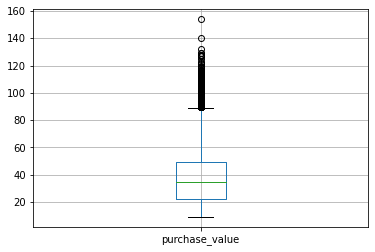

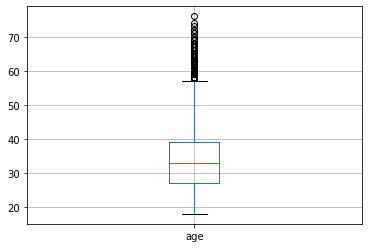

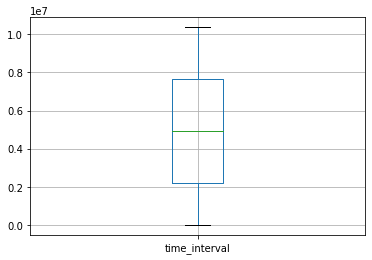

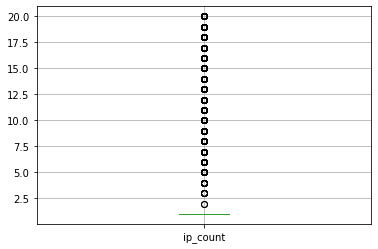

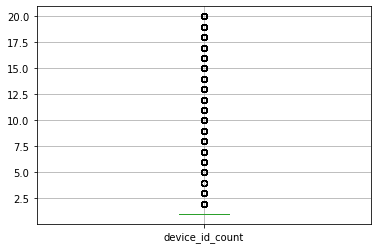

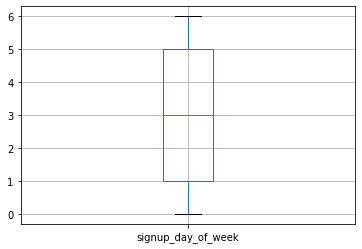

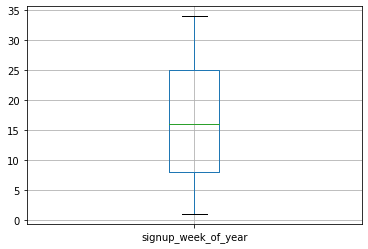

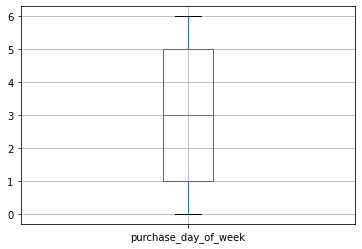

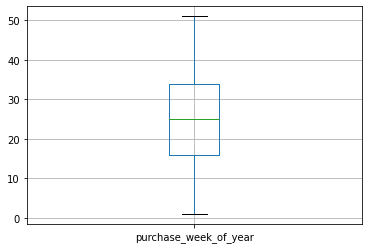

In [24]:
# boxplot
numeric_columns = []
numeric_columns.extend( ['purchase_value','age','time_interval','ip_count','device_id_count', 
                       'signup_day_of_week','signup_week_of_year','purchase_day_of_week' , 'purchase_week_of_year'] )


for col in numeric_columns:
    #print(col)
    new_fraud_df.boxplot(column = str(col))
    plt.show()

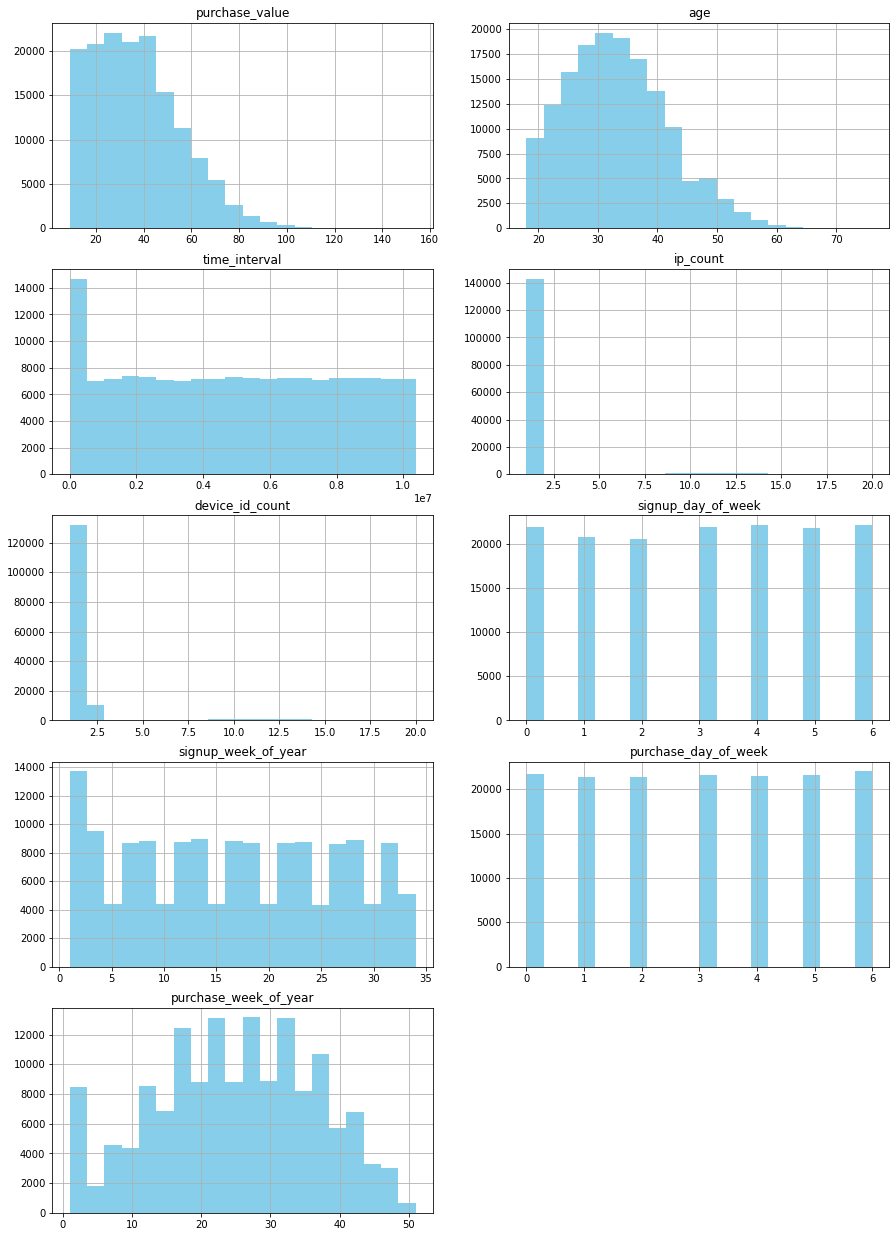

In [25]:
# subplot
fig_cols = 2
fig_rows = len(numeric_columns)

plt.figure(figsize=(15,40))
for i,col in enumerate (numeric_columns):
    plt.subplot(fig_rows,fig_cols,i+1)
    new_fraud_df[col].hist( color = "skyblue",bins=20)
    plt.title(str(col))
plt.show()

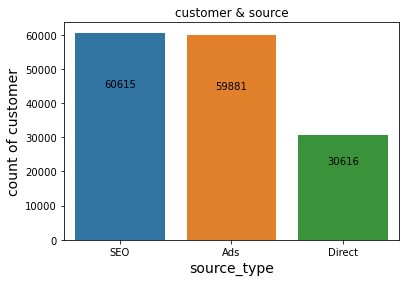

In [26]:
source_type = new_fraud_df['source'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

x_axis = source_type.index.tolist()
y_axis = source_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)


plt.title('customer & source')
plt.ylabel('count of customer', fontsize = 14)
plt.xlabel('source_type', fontsize = 14)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    text = f'{h:0.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')
    

plt.show()
##   SEO > ADS >Direct

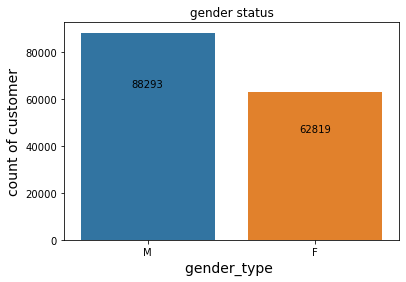

In [27]:
sex_type = new_fraud_df['sex'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

x_axis = sex_type.index.tolist()
y_axis = sex_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)


plt.title('gender status')
plt.ylabel('count of customer', fontsize = 14)
plt.xlabel('gender_type ', fontsize = 14)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    text= f'{h:0.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

plt.show()
## M > F

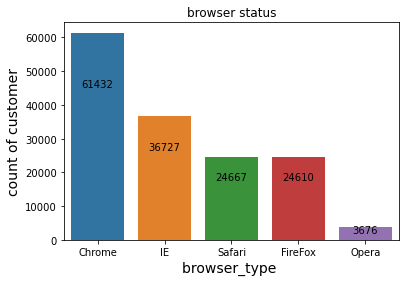

In [28]:
browser_type = new_fraud_df['browser'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

x_axis = browser_type.index.tolist()
y_axis = browser_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)


plt.title('browser status')
plt.ylabel('count of customer', fontsize = 14)
plt.xlabel('browser_type ', fontsize = 14)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    text= f'{h:0.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

plt.show()
## Chrome>IE>Safari>FireFox>Opera

### the relationship between  source , sex , browser and class

In [29]:
# source and  fraud or not

grouped_source = new_fraud_df.groupby(['source', 'class']).size().reset_index()
grouped_source.columns = ['source', 'class', 'count']


grouped_source

,source,class,count
0,Ads,0,54368
1,Ads,1,5513
2,Direct,0,27390
3,Direct,1,3226
4,SEO,0,55203
5,SEO,1,5412


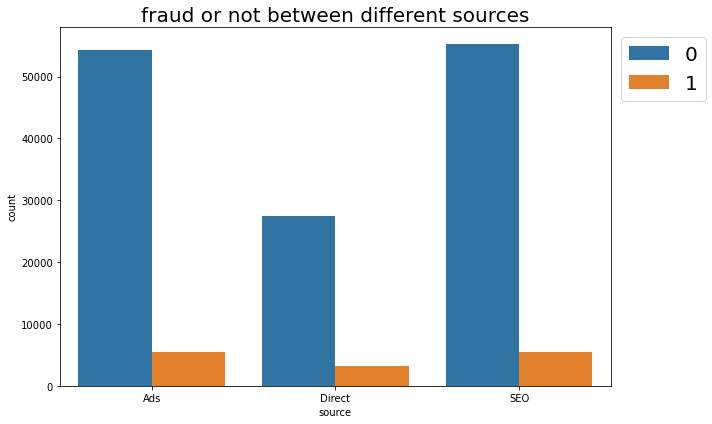

In [30]:
fig, ax = plt.subplots( figsize=(10, 6))

sns.barplot(data = grouped_source , x='source' , hue='class', y = 'count', ax=ax )
#ax.set_yscale("log")
ax.set_title('fraud or not between different sources', fontsize=20)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={ 'size'   : 20})


plt.tight_layout()
plt.show()

In [31]:
# sex and  fraud or not

grouped_sex = new_fraud_df.groupby(['sex', 'class']).size().reset_index()
grouped_sex.columns = ['sex', 'class', 'count']

grouped_sex

,sex,class,count
0,F,0,57102
1,F,1,5717
2,M,0,79859
3,M,1,8434


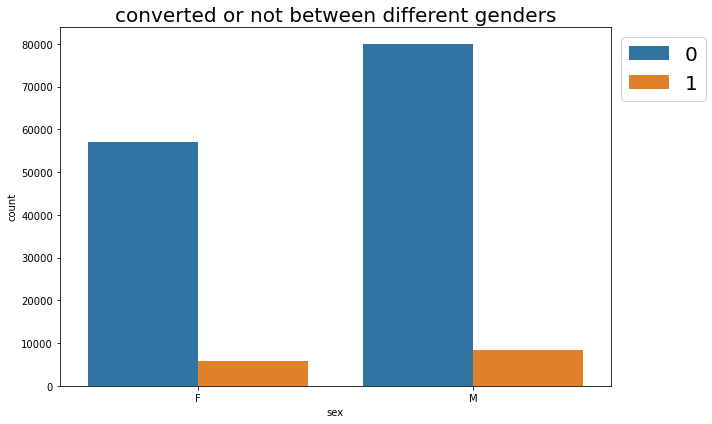

In [32]:
fig, ax = plt.subplots( figsize=(10, 6))

sns.barplot(data = grouped_sex , x='sex' , hue='class', y = 'count', ax = ax )
ax.set_title('converted or not between different genders', fontsize=20)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={ 'size'   : 20})


plt.tight_layout()
plt.show()

In [33]:
# browser and  fraud or not

grouped_browser = new_fraud_df.groupby(['browser', 'class']).size().reset_index()
grouped_browser.columns = ['browser', 'class', 'count']

grouped_browser

,browser,class,count
0,Chrome,0,55363
1,Chrome,1,6069
2,FireFox,0,22268
3,FireFox,1,2342
4,IE,0,33540
5,IE,1,3187
6,Opera,0,3348
7,Opera,1,328
8,Safari,0,22442
9,Safari,1,2225


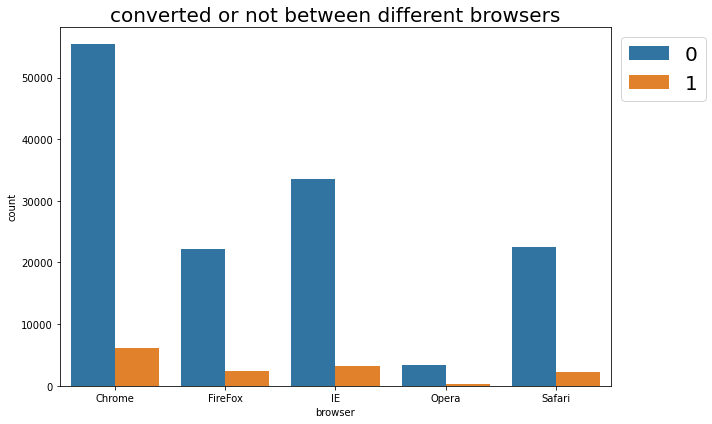

In [34]:

fig, ax = plt.subplots( figsize=(10, 6))


sns.barplot(data = grouped_browser , x='browser' , hue='class', y = 'count', ax = ax)

ax.set_title('converted or not between different browsers', fontsize=20)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={ 'size'   : 20})
plt.tight_layout()
plt.show()



<AxesSubplot:>

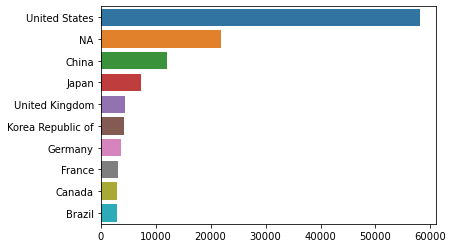

In [35]:
# check users by country 
grouped_country = new_fraud_df['country'].value_counts()

grouped_country_high = grouped_country[grouped_country > 2000]
sns.barplot(grouped_country_high.values, grouped_country_high.index)

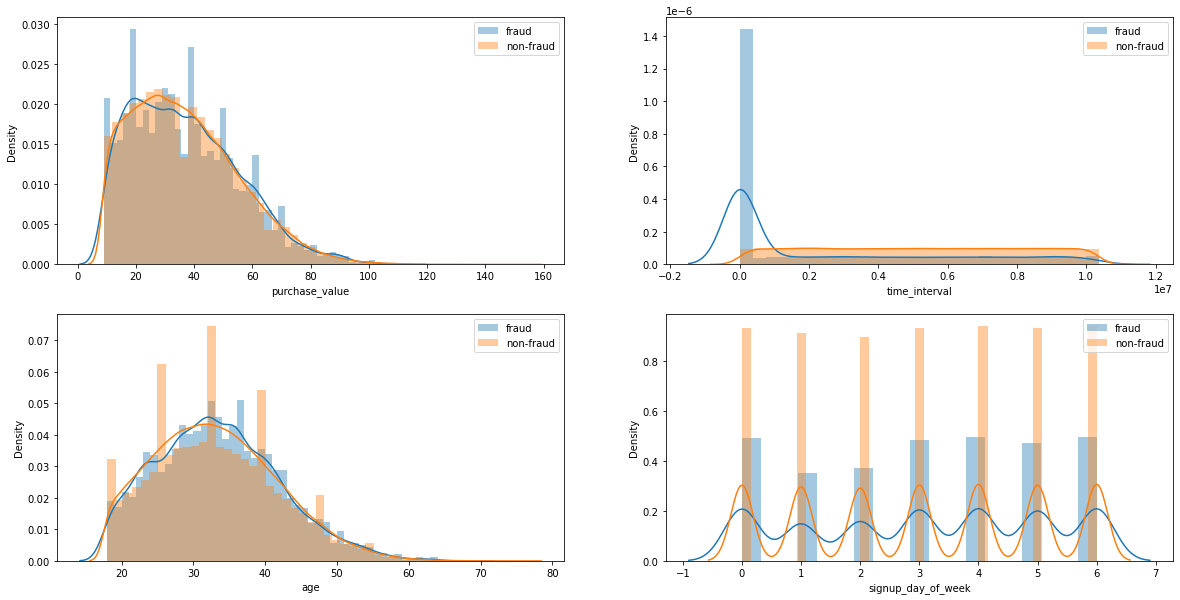

In [36]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

sns.distplot(fraud['purchase_value'], ax=ax[0][0], label='fraud')
sns.distplot(non_fraud['purchase_value'], ax=ax[0][0], label='non-fraud')
sns.distplot(fraud['time_interval'], ax=ax[0][1], label='fraud')
sns.distplot(non_fraud['time_interval'], ax=ax[0][1], label='non-fraud')
sns.distplot(fraud['age'], ax=ax[1][0], label='fraud')
sns.distplot(non_fraud['age'], ax=ax[1][0], label='non-fraud')
sns.distplot(fraud['signup_day_of_week'], ax=ax[1][1], label='fraud')
sns.distplot(non_fraud['signup_day_of_week'], ax=ax[1][1], label='non-fraud')
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()

### Prepare training and testing dataset

In [37]:
# one-hot encoding

new_fraud_df['is_male'] = (new_fraud_df.sex == 'M').astype(int)

source = pd.get_dummies(new_fraud_df['source'])
browser = pd.get_dummies(new_fraud_df['browser'])

new_fraud_df = pd.concat([new_fraud_df, source, browser], axis=1)

new_fraud_df.drop(columns=['source', 'browser', 'sex'], inplace=True)



country_count = new_fraud_df.country.value_counts()

new_fraud_df['country_count'] = new_fraud_df.country.map(country_count)
new_fraud_df.drop(['country'], axis=1, inplace=True)

new_fraud_df.head()

,purchase_value,age,class,time_interval,ip_count,device_id_count,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year,is_male,Ads,Direct,SEO,Chrome,FireFox,IE,Opera,Safari,country_count
0,34,39,0,4506682.0,1,1,1,9,5,16,1,0,0,1,1,0,0,0,0,7306
1,16,53,0,17944.0,1,1,6,23,0,24,0,1,0,0,1,0,0,0,0,58049
2,15,53,1,1.0,12,12,3,1,3,1,1,0,0,1,0,0,0,1,0,58049
3,44,41,0,492085.0,1,1,1,18,0,19,1,0,0,1,0,0,0,0,1,21966
4,39,45,0,4361461.0,1,1,1,30,2,37,1,1,0,0,0,0,0,0,1,58049


In [38]:
datas = new_fraud_df.copy()
datas.rename(columns={'class':'is_fraud'},inplace=True)
datas.head()

,purchase_value,age,is_fraud,time_interval,ip_count,device_id_count,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year,is_male,Ads,Direct,SEO,Chrome,FireFox,IE,Opera,Safari,country_count
0,34,39,0,4506682.0,1,1,1,9,5,16,1,0,0,1,1,0,0,0,0,7306
1,16,53,0,17944.0,1,1,6,23,0,24,0,1,0,0,1,0,0,0,0,58049
2,15,53,1,1.0,12,12,3,1,3,1,1,0,0,1,0,0,0,1,0,58049
3,44,41,0,492085.0,1,1,1,18,0,19,1,0,0,1,0,0,0,0,1,21966
4,39,45,0,4361461.0,1,1,1,30,2,37,1,1,0,0,0,0,0,0,1,58049


In [39]:

y = datas['is_fraud']
datas.drop(columns=['is_fraud'], inplace=True)
X = datas


X.head()


,purchase_value,age,time_interval,ip_count,device_id_count,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year,is_male,Ads,Direct,SEO,Chrome,FireFox,IE,Opera,Safari,country_count
0,34,39,4506682.0,1,1,1,9,5,16,1,0,0,1,1,0,0,0,0,7306
1,16,53,17944.0,1,1,6,23,0,24,0,1,0,0,1,0,0,0,0,58049
2,15,53,1.0,12,12,3,1,3,1,1,0,0,1,0,0,0,1,0,58049
3,44,41,492085.0,1,1,1,18,0,19,1,0,0,1,0,0,0,0,1,21966
4,39,45,4361461.0,1,1,1,30,2,37,1,1,0,0,0,0,0,0,1,58049


In [40]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [41]:
# GradientBoostingClassifier

GBclf = xgb.XGBClassifier(feature_names = datas.columns)
GBclf.fit(X_train,y_train)
y_pred = GBclf.predict(X_train)

[19:48:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "feature_names" } are not used.



In [42]:
# feature selection

feats = pd.Series(data=GBclf.feature_importances_, index=X_train.columns)
feats = feats.sort_values(ascending=False)
feats

device_id_count          0.408540
time_interval            0.267746
Direct                   0.044495
ip_count                 0.034105
FireFox                  0.018533
Opera                    0.018428
Chrome                   0.017692
IE                       0.017657
signup_day_of_week       0.017158
SEO                      0.016850
purchase_week_of_year    0.016441
purchase_day_of_week     0.016121
is_male                  0.016054
purchase_value           0.015671
country_count            0.015276
signup_week_of_year      0.015206
Ads                      0.015118
age                      0.014475
Safari                   0.014433
dtype: float32

In [43]:
# predict class labels 0/1 for the test set

probs = GBclf.predict(X_test)
predicted = [1 if i >= 0.5 else 0 for i in probs]

# generate evaluation metrics

print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, predicted)))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9570521021749681
roc_auc_score is: : 0.7734049751742583
f1_score is: : 0.7035175879396984
confusion_matrix is: 
        pred_0  pred_1
true_0   41077      40
true_1    1907    2310
recall = 0.5477827839696466
precision = 0.9829787234042553


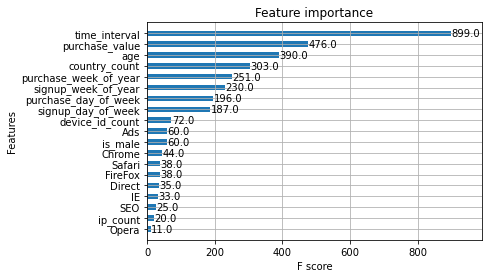

In [44]:
# show top 20th important features

GBclf.feature_names = datas.columns

plot_importance(GBclf,height=0.5,max_num_features=20)
plt.show()

In [45]:
datas.columns

Index(['purchase_value', 'age', 'time_interval', 'ip_count', 'device_id_count',
       'signup_day_of_week', 'signup_week_of_year', 'purchase_day_of_week',
       'purchase_week_of_year', 'is_male', 'Ads', 'Direct', 'SEO', 'Chrome',
       'FireFox', 'IE', 'Opera', 'Safari', 'country_count'],
      dtype='object')

In [46]:
GBclf.feature_importances_

array([0.01567145, 0.01447546, 0.26774606, 0.03410503, 0.40853968,
       0.01715823, 0.01520605, 0.01612055, 0.01644131, 0.01605353,
       0.01511772, 0.04449492, 0.01685042, 0.01769248, 0.01853265,
       0.01765726, 0.01842803, 0.01443294, 0.0152762 ], dtype=float32)

"\nimportance = pd.DataFrame(GBclf.feature_importances_, index = df_new.columns,                          columns=['importance']).sort_values('importance', ascending=False).reset_index()\nsns.barplot(x='importance', y='index', data=importance)\n"

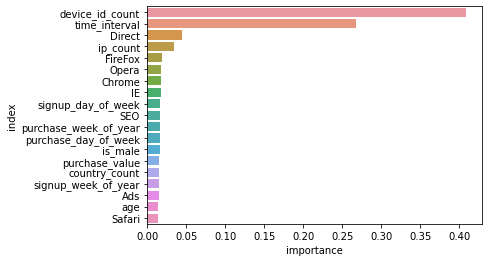

In [47]:

importance = pd.DataFrame(GBclf.feature_importances_, index = datas.columns,\
                          columns=['importance']).sort_values('importance', ascending=False).reset_index()
sns.barplot(x='importance', y='index', data=importance)



